In [1]:
import os

In [2]:
%pwd

'c:\\Users\\Admin\\Desktop\\Coccidiosis\\Coccidiosis-disease-classification\\research'

In [3]:
os.chdir("../")

In [5]:
%pwd

'c:\\Users\\Admin\\Desktop\\Coccidiosis\\Coccidiosis-disease-classification'

In [6]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list



@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    checkpoint_model_filepath: Path

In [7]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories
import tensorflow as tf

In [8]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])


    
    def get_prepare_callback_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.checkpoint_model_filepath)
        create_directories([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config = PrepareCallbacksConfig(
            root_dir=Path(config.root_dir),
            tensorboard_root_log_dir=Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath=Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    




    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "Chicken-fecal-images")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [9]:
import time

In [10]:
class PrepareCallback:
    def __init__(self, config: PrepareCallbacksConfig):
        self.config = config


    
    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f"tb_logs_at_{timestamp}",
        )
        return tf.keras.callbacks.TensorBoard(log_dir=tb_running_log_dir)
    

    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=str(self.config.checkpoint_model_filepath),
            save_best_only=True
        )


    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]


In [11]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [12]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )
    
    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)


    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator,
            callbacks=callback_list
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

        self.plot_training_history(history)

    def plot_training_history(self, history):
        # Plot training & validation accuracy values
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()



[2023-08-29 17:18:02,356: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-08-29 17:18:02,361: INFO: common: yaml file: params.yaml loaded successfully]
[2023-08-29 17:18:02,365: INFO: common: created directory at: artifacts]
[2023-08-29 17:18:02,369: INFO: common: created directory at: artifacts\prepare_callbacks\checkpoint_dir]
[2023-08-29 17:18:02,373: INFO: common: created directory at: artifacts\prepare_callbacks\tensorboard_log_dir]
[2023-08-29 17:18:02,397: INFO: common: created directory at: artifacts\training]
Found 78 images belonging to 2 classes.
Found 312 images belonging to 2 classes.
Epoch 1/21
19/19 [==============================] - ETA: 0s - loss: 12.4849 - accuracy: 0.5405 

c:\Users\Admin\Desktop\Coccidiosis\Coccidiosis-disease-classification\chicken\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 456s 24s/step - loss: 12.4849 - accuracy: 0.5405 - val_loss: 15.6462 - val_accuracy: 0.6094
Epoch 2/21
19/19 [==============================] - 625s 33s/step - loss: 7.7373 - accuracy: 0.6284 - val_loss: 7.1922 - val_accuracy: 0.4375
Epoch 3/21
19/19 [==============================] - 480s 26s/step - loss: 4.6035 - accuracy: 0.7007 - val_loss: 24.7341 - val_accuracy: 0.3906
Epoch 4/21
19/19 [==============================] - 391s 21s/step - loss: 2.0367 - accuracy: 0.8682 - val_loss: 0.8571 - val_accuracy: 0.8906
Epoch 5/21
19/19 [==============================] - 407s 22s/step - loss: 2.5359 - accuracy: 0.7872 - val_loss: 0.8695 - val_accuracy: 0.8906
Epoch 6/21
19/19 [==============================] - 528s 28s/step - loss: 0.7424 - accuracy: 0.9046 - val_loss: 5.1485 - val_accuracy: 0.6719
Epoch 7/21
19/19 [==============================] - 621s 33s/step - loss: 1.3265 - accuracy: 0.8412 - val_loss: 0.8570 - val_accuracy: 0.8906
Epoch 8/21
19/

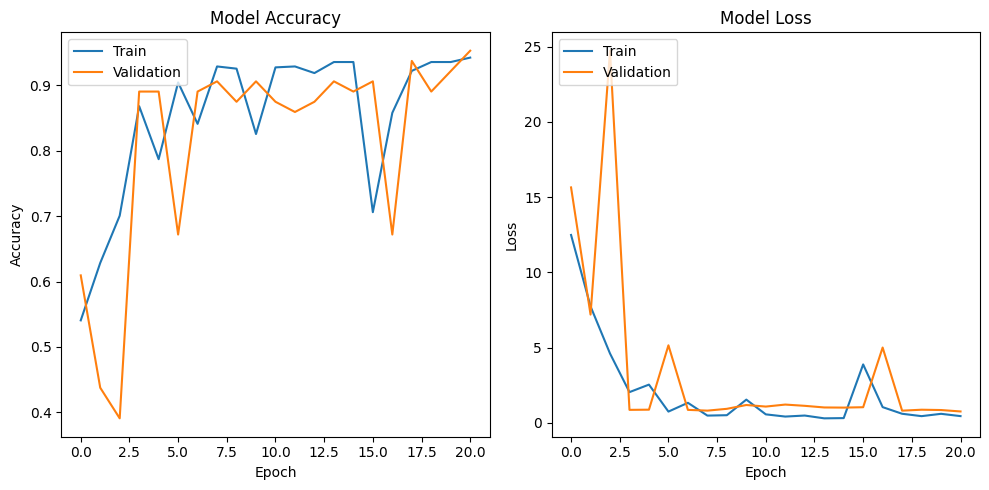

In [13]:
try:
    config = ConfigurationManager()
    prepare_callbacks_config = config.get_prepare_callback_config()
    prepare_callbacks = PrepareCallback(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_callbacks()

    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(
        callback_list=callback_list
    )
    
except Exception as e:
    raise e

In [36]:
# training.train(
#     callback_list = callback_list
# )

19/19 [==============================] - ETA: 0s - loss: 14.5549 - accuracy: 0.5169 

c:\Users\Admin\Desktop\Coccidiosis\Coccidiosis-disease-classification\chicken\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 636s 33s/step - loss: 14.5549 - accuracy: 0.5169 - val_loss: 0.7845 - val_accuracy: 0.8594
